<a href="https://colab.research.google.com/github/zahraafirdausi/Optimization-of-job-shop-scheduling-problem-using-GA./blob/main/Code_P1_K5_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#OPTIMASI PERMASALAHAN JOB SHOP SCHEDULING MENGGUNAKAN GENETIC ALGORITHM DAN CONSTRAINT SATISFACTION PROBLEM#

Disusun oleh Kelompok 5 Kelas P1:

- Zahra Aulia Firdausi	    	(G64180030)
- Putri Melanita Londong Bua	(G64180053)
- Syukriyatul Hanifa		    	(G64180062)
- Annisa Faradila		         	(G64180074)
- Hendrika Anggriawan		      (G64180088)

Untuk pengalaman terbaik dalam memakai kode ini, gunakan Google Collab. Cukup sesuaikan nama path directory saja. Pastikan di dalam directory tersebut telah terdapat file dataset yang dibutuhkan.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# set working directory
import os

# Atur path directory Anda di bawah ini
contoh: path = "/content/drive/MyDrive/Kuliah/Smt 6/Sisdas/PROJEK SISDAS"
# path = ""

os.chdir(path)
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1kuxb5WYuknav9kth1zIr9yWNSrvvTIwx/Sisdas/PROJEK SISDAS'

In [ ]:
""" Defined function for static initial data for Production Planning """

#importing libraries
import pandas as pd
import openpyxl as xl
import json

def data_excel_json(excel_sheet):
    """ convert excel into json """
    data_excel = xl.load_workbook(excel_sheet)
    data = {}
    sheet_name = data_excel.sheetnames
    for sheet in sheet_name:
        wb_sheet = data_excel[sheet]
        cell_values = wb_sheet.values
        df =  pd.DataFrame(cell_values, columns=next(cell_values))
        df.iloc[:, 0] = df.iloc[:, 0].apply(lambda x : x.strip())
        df.index = df.iloc[:, 0]
        df.drop(columns = df.columns[0], inplace=True)
        data[sheet] = df.T.to_dict()
    return data


In [ ]:
!pip install chart_studio

In [ ]:
import chart_studio.plotly as py

In [ ]:
''' Solving job shop scheduling problem by gentic algorithm '''

# importing required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import chart_studio.plotly as py
import plotly.figure_factory as ff
import datetime
import time
import copy
import openpyxl as xl
import json


def json_to_df(json_data):
    """ convert json into excel """
    dict_data = {}
    for key in json_data.keys():
        dict_data[key] = pd.DataFrame(json_data.get(key)).T

    return dict_data


def generate_initial_population(population_size, num_gene):

    """ generate initial population for Genetic Algorithm """

    best_list, best_obj = [], []
    population_list = []
    makespan_record = []

    for i in range(population_size):
        nxm_random_num = list(np.random.permutation(num_gene))
        population_list.append(nxm_random_num)
        for j in range(num_gene):
            population_list[i][j] = population_list[i][j] % num_job

    return population_list



def job_schedule(data_dict, population_size = 100, crossover_rate = 0.8, mutation_rate = 0.02, mutation_selection_rate = 0.1, num_iteration = 1000):

    """ initialize genetic algorithm parameters and read data """
    data_json  = json_to_df(data_dict)
    machine_sequence_tmp = data_json['Machines Sequence']
    process_time_tmp = data_json['Processing Time']

    df_shape = process_time_tmp.shape
    num_machines = df_shape[1] # Banyaknya mesin
    num_job = df_shape[0] # Banyaknya pekerja
    num_gene = num_machines * num_job # Banyaknya gen dalam satu kromosom
    num_mutation_jobs = round(num_gene * mutation_selection_rate)

    process_time = [list(map(int, process_time_tmp.iloc[i])) for i in range(num_job)]
    machine_sequence = [list(map(int, machine_sequence_tmp.iloc[i])) for i in range(num_job)]

    Tbest = 999999999999999

    best_list, best_obj = [], []
    population_list = []
    makespan_record = []

    for i in range(population_size):
        nxm_random_num = list(np.random.permutation(num_gene))
        population_list.append(nxm_random_num)
        for j in range(num_gene):
            population_list[i][j] = population_list[i][j] % num_job 

    for iteration in range(num_iteration):
        Tbest_now = 99999999999

        """ Two Point Cross-Over """
        parent_list = copy.deepcopy(population_list)
        offspring_list = copy.deepcopy(population_list) # Memilih random kromosom parent yang akan disilangkan
        pop_random_size = list(np.random.permutation(population_size))

        for size in range(int(population_size/2)):
            crossover_prob = np.random.rand()
            if crossover_rate >= crossover_prob:
                parent_1 = population_list[pop_random_size[2*size]][:]
                parent_2 = population_list[pop_random_size[2*size+1]][:]

                child_1 = parent_1[:]
                child_2 = parent_2[:]
                cutpoint = list(np.random.choice(num_gene, 2, replace=False)) # Memilih 2 titik crossover
                cutpoint.sort()

                child_1[cutpoint[0]:cutpoint[1]] = parent_2[cutpoint[0]:cutpoint[1]]
                child_2[cutpoint[0]:cutpoint[1]] = parent_1[cutpoint[0]:cutpoint[1]]
                offspring_list[pop_random_size[2*size]] = child_1[:]
                offspring_list[pop_random_size[2*size+1]] = child_2[:]


        for pop in range(population_size):

            """ Repairment """
            job_count = {}
            larger, less = [], [] # Menyimpan informasi gen yang jumlahnya tidak memenuhi syarat
            for job in range(num_job):
                if job in offspring_list[pop]:
                    count = offspring_list[pop].count(job)
                    pos = offspring_list[pop].index(job)
                    job_count[job] = [count, pos]
                else:
                    count = 0
                    job_count[job] = [count, 0]

                if count > num_machines:
                    larger.append(job)
                elif count < num_machines:
                    less.append(job)
                    
            for large in range(len(larger)):
                change_job = larger[large]
                while job_count[change_job][0] > num_machines:
                    for les in range(len(less)):
                        if job_count[less[les]][0] < num_machines:                    
                            offspring_list[pop][job_count[change_job][1]] = less[les]
                            job_count[change_job][1] = offspring_list[pop].index(change_job)
                            job_count[change_job][0] = job_count[change_job][0]-1
                            job_count[less[les]][0] = job_count[less[les]][0]+1                    
                        if job_count[change_job][0] == num_machines:
                            break     
    

        
        for off_spring in range(len(offspring_list)):

            """ Mutations """
            mutation_prob = np.random.rand()
            if mutation_rate >= mutation_prob:
                m_change = list(np.random.choice(num_gene, num_mutation_jobs, replace=False)) 
                t_value_last = offspring_list[off_spring][m_change[0]] 
                for i in range(num_mutation_jobs-1):
                    offspring_list[off_spring][m_change[i]] = offspring_list[off_spring][m_change[i+1]] 
                offspring_list[off_spring][m_change[num_mutation_jobs-1]] = t_value_last 



        """ fitness value (calculate makespan) """
        total_chromosome = copy.deepcopy(parent_list) + copy.deepcopy(offspring_list) 
        chrom_fitness, chrom_fit = [], []
        total_fitness = 0
        for pop_size in range(population_size*2):
            j_keys = [j for j in range(num_job)]
            key_count = {key:0 for key in j_keys}
            j_count = {key:0 for key in j_keys}
            m_keys = [j+1 for j in range(num_machines)]
            m_count = {key:0 for key in m_keys}
            
            for i in total_chromosome[pop_size]:
                gen_t = int(process_time[i][key_count[i]])
                gen_m = int(machine_sequence[i][key_count[i]])
                j_count[i] = j_count[i] + gen_t
                m_count[gen_m] = m_count[gen_m] + gen_t
                
                if m_count[gen_m] < j_count[i]:
                    m_count[gen_m] = j_count[i]
                elif m_count[gen_m] > j_count[i]:
                    j_count[i] = m_count[gen_m]
                
                key_count[i] = key_count[i] + 1
        
            makespan = max(j_count.values())
            chrom_fitness.append(1/makespan)
            chrom_fit.append(makespan)
            total_fitness = total_fitness + chrom_fitness[pop_size]
        

        """ Selection (roulette wheel approach) """
        pk, qk = [], []
        
        for size in range(population_size * 2):
            pk.append(chrom_fitness[size] / total_fitness)
        for size in range(population_size * 2):
            cumulative = 0

            for j in range(0, size+1):
                cumulative = cumulative + pk[j]
            qk.append(cumulative)
        
        selection_rand = [np.random.rand() for i in range(population_size)]
        
        for pop_size in range(population_size):
            if selection_rand[pop_size] <= qk[0]:
                population_list[pop_size] = copy.deepcopy(total_chromosome[0])
            else:
                for j in range(0, population_size * 2-1):
                    if selection_rand[pop_size] > qk[j] and selection_rand[pop_size] <= qk[j+1]:
                        population_list[pop_size] = copy.deepcopy(total_chromosome[j+1])
                        break


        """ comparison """
        for pop_size in range(population_size * 2):
            if chrom_fit[pop_size] < Tbest_now:
                Tbest_now = chrom_fit[pop_size]
                sequence_now = copy.deepcopy(total_chromosome[pop_size])
        if Tbest_now <= Tbest:
            Tbest = Tbest_now
            sequence_best = copy.deepcopy(sequence_now)
            
        makespan_record.append(Tbest)

    """ Results - Makespan """

    print("optimal sequence", sequence_best)
    print("optimal value:%f"%Tbest)
    print("\n")

    plt.plot([i for i in range(len(makespan_record))],makespan_record,'b')
    plt.ylabel('makespan', fontsize=15)
    plt.xlabel('generation', fontsize=15)
    plt.show()


    """ plot gantt chart """

    m_keys = [j+1 for j in range(num_machines)]
    j_keys = [j for j in range(num_job)]
    key_count = {key:0 for key in j_keys}
    j_count = {key:0 for key in j_keys}
    m_count = {key:0 for key in m_keys}
    j_record = {}
    for i in sequence_best:
        gen_t = int(process_time[i][key_count[i]])
        gen_m = int(machine_sequence[i][key_count[i]])
        j_count[i] = j_count[i] + gen_t
        m_count[gen_m] = m_count[gen_m] + gen_t

        if m_count[gen_m] < j_count[i]:
            m_count[gen_m] = j_count[i]
        elif m_count[gen_m] > j_count[i]:
            j_count[i] = m_count[gen_m]

        start_time = str(datetime.timedelta(seconds = j_count[i] - process_time[i][key_count[i]]))
        end_time = str(datetime.timedelta(seconds = j_count[i]))

        j_record[(i, gen_m)] = [start_time, end_time]

        key_count[i] = key_count[i] + 1


    df = []
    for m in m_keys:
        for j in j_keys:
            df.append(dict(Task='Mesin %s'%(m), Start='2021-06-22 %s'%(str(j_record[(j,m)][0])), \
                            Finish='2021-06-22 %s'%(str(j_record[(j,m)][1])),Resource='Pekerja %s'%(j+1)))
    
    df_ = pd.DataFrame(df)
    df_.Start = pd.to_datetime(df_['Start'])
    df_.Finish = pd.to_datetime(df_['Finish'])
    start = df_.Start.min()
    end = df_.Finish.max()

    df_.Start = df_.Start.apply(lambda x: x.strftime('%Y-%m-%dT%H:%M:%S'))
    df_.Finish = df_.Finish.apply(lambda x: x.strftime('%Y-%m-%dT%H:%M:%S'))
    data = df_.to_dict('record')

    final_data ={
        'start':start.strftime('%Y-%m-%dT%H:%M:%S'),
        'end':end.strftime('%Y-%m-%dT%H:%M:%S'),
        'data':data}
    
    color = ['#7c3933', '#a1fcba', '#5226f5', '#b49dda', '#df1769',
             '#873dd2', '#cd02f6', '#d837ab', '#00867f', '#4c58e4',
             '#6e69c1', '#fe7a69', '#9c4688', '#1f5bb3', '#60c9d0', 
             '#35c9c1', '#b35985', '#a1fcbf', '#cbc086', '#03389f', 
             '#9edeab', '#d99458', '#9ebe2a', '#74950b', '#b3b1c0',
             '#f54b5d', '#afc8c3', '#a2f770', '#9a0dff', '#e2c947']
    fig = ff.create_gantt(df, colors = color ,index_col='Resource', show_colorbar=True, group_tasks=True, showgrid_x=True, title='Job shop Schedule')
    fig.show()
    return final_data, df

optimal sequence [6, 7, 11, 10, 14, 8, 6, 12, 0, 0, 4, 5, 13, 6, 1, 5, 3, 4, 9, 2, 5, 6, 8, 4, 11, 5, 3, 2, 14, 13, 9, 4, 0, 10, 3, 10, 0, 4, 4, 6, 13, 7, 14, 11, 0, 4, 2, 7, 8, 3, 1, 6, 0, 9, 8, 5, 7, 5, 5, 11, 3, 10, 9, 10, 3, 8, 7, 9, 14, 7, 13, 1, 10, 12, 11, 9, 11, 6, 12, 11, 6, 7, 4, 9, 10, 3, 5, 10, 6, 3, 12, 11, 11, 11, 2, 1, 2, 5, 12, 12, 0, 4, 7, 10, 8, 7, 9, 7, 1, 5, 14, 14, 12, 8, 3, 2, 10, 13, 3, 12, 1, 5, 2, 11, 7, 6, 9, 3, 13, 11, 2, 14, 0, 1, 13, 1, 2, 9, 14, 6, 13, 4, 8, 8, 7, 5, 14, 4, 5, 6, 11, 8, 0, 10, 9, 13, 13, 8, 12, 1, 9, 11, 3, 10, 0, 12, 1, 3, 13, 2, 2, 13, 4, 14, 5, 1, 11, 12, 4, 1, 7, 10, 12, 14, 9, 4, 14, 13, 14, 6, 0, 3, 0, 0, 1, 12, 2, 1, 8, 8, 10, 9, 8, 2, 1, 6, 13, 0, 7, 2, 5, 13, 12, 8, 0, 2, 10, 14, 9, 14, 12, 3, 7, 6, 4]
optimal value:1535.000000




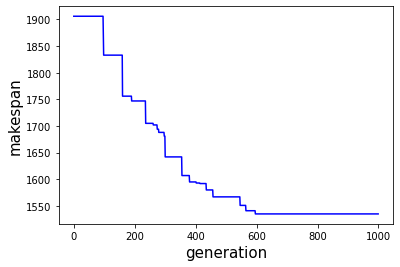

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:1490: FutureWarning:

Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.



In [ ]:
""" Job_Shop_Schedule """
np.random.seed(123)
data = data_excel_json('dataset.xlsx')
schedule = job_schedule(data_dict=data)